# CPU vs GPU Performance Analysis

This notebook analyzes the performance of CPU vs GPU training across different
batch sizes and data sizes (num_sessions), comparing:
- **elapsed_seconds**: Processing time only (training time)
- **wandb_runtime**: Total time including overhead (memory loading, initialization)

In [1]:
# Autoload notebook extension for improved usability
%load_ext autoreload
%autoreload 2

## 1. Initialize Client and Fetch Data

In [2]:
from aind_disrnn_result_access import WandbClient
import pandas as pd

client = WandbClient()

wandb: [wandb.Api()] Loaded credentials for https://api.wandb.ai from WANDB_API_KEY.


In [3]:
# Get runs from han_cpu_gpu_test project
df = client.get_runs_dataframe(
    project="han_cpu_gpu_test",
    per_page=100
)

print(f"Total runs: {len(df)}")
df.head()

Total runs: 73


,id,name,state,created_at,url,tags,config.data.seed,config.data.task.mean,config.data.task.seed,config.data.task.type,...,config.data.subject_ids,config.data.multisubject,config.data.ignore_policy,summary.fig/update_rule_4._type,summary.fig/update_rule_4.format,summary.fig/update_rule_4.height,summary.fig/update_rule_4.path,summary.fig/update_rule_4.sha256,summary.fig/update_rule_4.size,summary.fig/update_rule_4.width
0,0q45cmry,1gpu4cpu64G_bs2048_wu500_5_3_4_0_beta0.001_lr0...,finished,2026-02-06T22:20:05Z,https://wandb.ai/AIND-disRNN/han_cpu_gpu_test/...,"batch_size,cpu,disrnn,synthetic",0,0.0,0.0,random_walk,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,lzij3ybo,1gpu4cpu64G_bs256_wu500_5_3_4_0_beta0.001_lr0....,finished,2026-02-06T22:20:04Z,https://wandb.ai/AIND-disRNN/han_cpu_gpu_test/...,"batch_size,cpu,disrnn,synthetic",0,0.0,0.0,random_walk,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0ec4vqq6,1gpu4cpu64G_bs1024_wu500_5_3_4_0_beta0.001_lr0...,finished,2026-02-06T22:20:04Z,https://wandb.ai/AIND-disRNN/han_cpu_gpu_test/...,"batch_size,cpu,disrnn,synthetic",0,0.0,0.0,random_walk,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,cju5e411,1gpu4cpu64G_bs2048_wu500_5_3_4_0_beta0.001_lr0...,finished,2026-02-06T22:20:03Z,https://wandb.ai/AIND-disRNN/han_cpu_gpu_test/...,"batch_size,cpu,disrnn,synthetic",0,0.0,0.0,random_walk,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1mqgpxrq,1gpu4cpu64G_bs128_wu500_5_3_4_0_beta0.001_lr0....,finished,2026-02-06T22:20:03Z,https://wandb.ai/AIND-disRNN/han_cpu_gpu_test/...,"batch_size,cpu,disrnn,synthetic",0,0.0,0.0,random_walk,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 2. Filter Runs by num_sessions

In [4]:
# Filter for num_sessions in (100, 1000, 10000)
filtered_df = df[
    df['config.data.num_sessions'].isin([100, 1000, 10000])
]

print(f"Filtered runs: {len(filtered_df)}")
print(f"\nnum_sessions distribution:")
print(filtered_df['config.data.num_sessions'].value_counts().sort_index())

Filtered runs: 30

num_sessions distribution:
config.data.num_sessions
100.0      10
1000.0     10
10000.0    10
Name: count, dtype: int64


## 3. Identify CPU vs GPU from Run Name

In [5]:
# Check run name patterns
print("Sample run names:")
for name in filtered_df['name'].head(10):
    print(f"  {name}")

# Identify device type from run name
# Names with 'gpu' indicate GPU runs, others are CPU-only
filtered_df = filtered_df.copy()
filtered_df['device'] = filtered_df['name'].apply(
    lambda x: 'GPU' if 'gpu' in x.lower() else 'CPU'
)

print(f"\nDevice distribution:")
print(filtered_df['device'].value_counts())

Sample run names:
  1gpu4cpu64G_bs2048_wu500_5_3_4_0_beta0.001_lr0.005_grad_clip1
  1gpu4cpu64G_bs256_wu500_5_3_4_0_beta0.001_lr0.005_grad_clip1
  1gpu4cpu64G_bs1024_wu500_5_3_4_0_beta0.001_lr0.005_grad_clip1
  1gpu4cpu64G_bs2048_wu500_5_3_4_0_beta0.001_lr0.005_grad_clip1
  1gpu4cpu64G_bs128_wu500_5_3_4_0_beta0.001_lr0.005_grad_clip1
  1gpu4cpu64G_bs1024_wu500_5_3_4_0_beta0.001_lr0.005_grad_clip1
  1gpu4cpu64G_bs512_wu500_5_3_4_0_beta0.001_lr0.005_grad_clip1
  1gpu4cpu64G_bs512_wu500_5_3_4_0_beta0.001_lr0.005_grad_clip1
  1gpu4cpu64G_bs2048_wu500_5_3_4_0_beta0.001_lr0.005_grad_clip1
  1gpu4cpu64G_bs512_wu500_5_3_4_0_beta0.001_lr0.005_grad_clip1

Device distribution:
device
GPU    15
CPU    15
Name: count, dtype: int64


## 4. Extract Batch Size (patch_size)

In [6]:
# Get batch_size (used as patch_size for this analysis)
batch_sizes = filtered_df['config.data.batch_size'].unique()
print(f"Unique batch sizes: {sorted(batch_sizes)}")

Unique batch sizes: [np.float64(128.0), np.float64(256.0), np.float64(512.0), np.float64(1024.0), np.float64(2048.0)]


## 5. Prepare Data for Plotting

In [7]:
# Select relevant columns - keep id for merging
plot_df = filtered_df[[
    'id',
    'name',
    'config.data.num_sessions',
    'config.data.batch_size',
    'summary.elapsed_seconds',
    'summary._wandb.runtime',
    'device'
]].copy()

# Rename with dot notation for clarity
plot_df = plot_df.rename(columns={
    'config.data.num_sessions': 'data.num_sessions',
    'config.data.batch_size': 'data.batch_size',
    'summary.elapsed_seconds': 'summary.elapsed_seconds',
    'summary._wandb.runtime': 'summary._wandb.runtime'
})

# Sort by data.num_sessions and data.batch_size
plot_df = plot_df.sort_values(['data.num_sessions', 'data.batch_size'])

# Calculate overhead (difference between total runtime and processing time)
plot_df['overhead_seconds'] = plot_df['summary._wandb.runtime'] - plot_df['summary.elapsed_seconds']
plot_df['overhead_pct'] = (plot_df['overhead_seconds'] / plot_df['summary._wandb.runtime'] * 100).round(1)

print(plot_df[['name', 'data.num_sessions', 'data.batch_size', 
               'summary.elapsed_seconds', 'summary._wandb.runtime', 
               'overhead_seconds', 'overhead_pct']].head(10))

                                                 name  data.num_sessions  \
10  1gpu4cpu64G_bs128_wu500_5_3_4_0_beta0.001_lr0....              100.0   
29  4cpu64G_bs128_wu500_5_3_4_0_beta0.001_lr0.005_...              100.0   
14  1gpu4cpu64G_bs256_wu500_5_3_4_0_beta0.001_lr0....              100.0   
26  4cpu64G_bs256_wu500_5_3_4_0_beta0.001_lr0.005_...              100.0   
7   1gpu4cpu64G_bs512_wu500_5_3_4_0_beta0.001_lr0....              100.0   
17  4cpu64G_bs512_wu500_5_3_4_0_beta0.001_lr0.005_...              100.0   
5   1gpu4cpu64G_bs1024_wu500_5_3_4_0_beta0.001_lr0...              100.0   
22  4cpu64G_bs1024_wu500_5_3_4_0_beta0.001_lr0.005...              100.0   
8   1gpu4cpu64G_bs2048_wu500_5_3_4_0_beta0.001_lr0...              100.0   
18  4cpu64G_bs2048_wu500_5_3_4_0_beta0.001_lr0.005...              100.0   

    data.batch_size  summary.elapsed_seconds  summary._wandb.runtime  \
10            128.0              1780.984864                  1979.0   
29            128.0

## 6. Create Plot: Time vs num_sessions (with and without overhead)

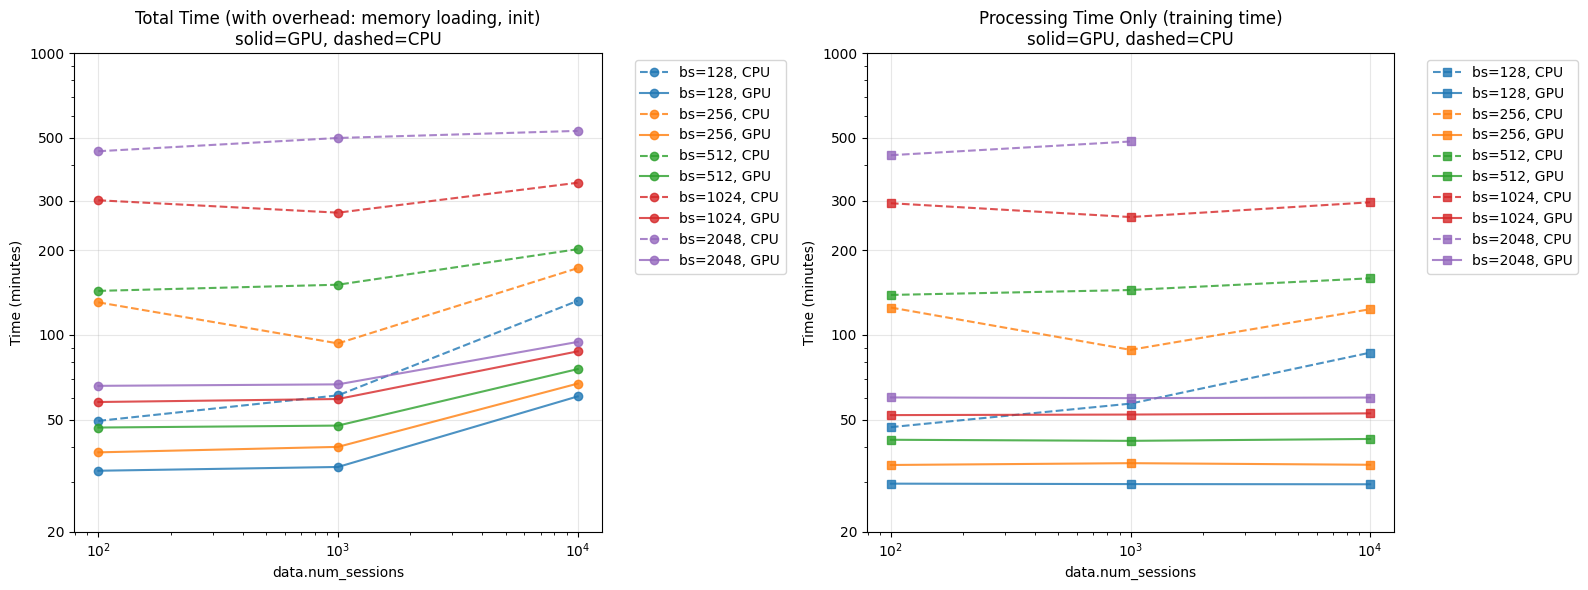

In [8]:
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

# Set up the plot with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Get unique batch sizes and devices
batch_sizes = sorted(plot_df['data.batch_size'].unique())
devices = ['CPU', 'GPU']

# Define colors for each batch size
colors = plt.cm.tab10(range(len(batch_sizes)))

# Define explicit y-axis ticks (in minutes)
yticks = [20, 50, 100, 200, 300, 500, 1000]

# --- Left plot: With overhead (summary._wandb.runtime) ---
for i, bs in enumerate(batch_sizes):
    for device in devices:
        data = plot_df[
            (plot_df['data.batch_size'] == bs) &
            (plot_df['device'] == device)
        ].sort_values('data.num_sessions')
        
        if len(data) > 0 and data['summary._wandb.runtime'].notna().any():
            linestyle = '-' if device == 'GPU' else '--'
            label = f'bs={int(bs)}, {device}'
            
            ax1.plot(
                data['data.num_sessions'],
                data['summary._wandb.runtime'] / 60,
                marker='o',
                linestyle=linestyle,
                color=colors[i],
                label=label,
                alpha=0.8
            )

ax1.set_xlabel('data.num_sessions')
ax1.set_ylabel('Time (minutes)')
ax1.set_title('Total Time (with overhead: memory loading, init)\nsolid=GPU, dashed=CPU')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(True, alpha=0.3)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_yticks(yticks)
ax1.get_yaxis().set_major_formatter(ScalarFormatter())

# --- Right plot: Without overhead (summary.elapsed_seconds only) ---
for i, bs in enumerate(batch_sizes):
    for device in devices:
        data = plot_df[
            (plot_df['data.batch_size'] == bs) &
            (plot_df['device'] == device)
        ].sort_values('data.num_sessions')
        
        if len(data) > 0 and data['summary.elapsed_seconds'].notna().any():
            linestyle = '-' if device == 'GPU' else '--'
            label = f'bs={int(bs)}, {device}'
            
            ax2.plot(
                data['data.num_sessions'],
                data['summary.elapsed_seconds'] / 60,
                marker='s',
                linestyle=linestyle,
                color=colors[i],
                label=label,
                alpha=0.8
            )

ax2.set_xlabel('data.num_sessions')
ax2.set_ylabel('Time (minutes)')
ax2.set_title('Processing Time Only (training time)\nsolid=GPU, dashed=CPU')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.grid(True, alpha=0.3)
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_yticks(yticks)
ax2.get_yaxis().set_major_formatter(ScalarFormatter())

plt.tight_layout()
plt.show()

## 7. Overhead Analysis

In [9]:
# Group by device and data.num_sessions to see average overhead
overhead_summary = plot_df.groupby(
    ['device', 'data.num_sessions']
)[['summary.elapsed_seconds', 'summary._wandb.runtime', 'overhead_seconds', 'overhead_pct']].mean()

print("Average time metrics by device and data.num_sessions:")
print(overhead_summary)

Average time metrics by device and data.num_sessions:
                          summary.elapsed_seconds  summary._wandb.runtime  \
device data.num_sessions                                                    
CPU    100.0                         12465.077265                 12873.0   
       1000.0                        12455.654676                 12921.8   
       10000.0                        9968.308154                 16596.8   
GPU    100.0                          2624.844902                  2905.2   
       1000.0                         2624.064201                  2974.4   
       10000.0                        2635.676425                  4624.4   

                          overhead_seconds  overhead_pct  
device data.num_sessions                                  
CPU    100.0                    407.922735          3.60  
       1000.0                   466.145324          4.42  
       10000.0                 2830.441846         24.75  
GPU    100.0                    28

## 8. Summary Statistics (Processing Time Only)

In [10]:
# Group by device, data.num_sessions, and data.batch_size
summary = plot_df.groupby(
    ['device', 'data.num_sessions', 'data.batch_size']
)['summary.elapsed_seconds'].mean().unstack(fill_value=None)

print("Average elapsed time (seconds) by configuration:")
print(summary)

Average elapsed time (seconds) by configuration:
data.batch_size                128.0        256.0        512.0         1024.0  \
device data.num_sessions                                                        
CPU    100.0              2826.016939  7508.249438  8322.186712  17602.748805   
       1000.0             3424.512534  5314.422302  8663.038978  15725.001368   
       10000.0            5193.735566  7406.410477  9533.353957  17739.732616   
GPU    100.0              1780.984864  2074.458825  2548.951652   3117.877574   
       1000.0             1774.693663  2105.340669  2526.675028   3132.028254   
       10000.0            1771.868139  2078.005200  2565.899305   3162.818835   

data.batch_size                 2048.0  
device data.num_sessions                
CPU    100.0              26066.184430  
       1000.0             29151.298200  
       10000.0                     NaN  
GPU    100.0               3601.951596  
       1000.0              3581.583392  
       10000.0 

## 9. Find First Time Valid Loss Crosses Threshold (After Warmup)

In [26]:
def find_first_cross_time(run_id, threshold, n_warmup_steps=0, project="han_cpu_gpu_test"):
    """Find the first time valid_loss drops below a threshold after warmup.
    
    Parameters
    ----------
    run_id : str
        The W&B run ID.
    threshold : float
        The valid_loss threshold to check.
    n_warmup_steps : int
        Number of warmup steps to skip. Defaults to 0.
    project : str
        The W&B project name.
    
    Returns
    -------
    dict or None
        Dictionary with 'run_id', 'threshold', 'first_cross_step', 
        'first_cross_wall_time', 'valid_loss_at_cross', or None if 
        valid_loss never crosses below threshold after warmup.
    """
    history = client.get_run_history(
        run_id, 
        project=project,
        keys=['valid/loss']
    )
    
    # Filter to steps after warmup
    history = history[history['_step'] >= n_warmup_steps]
    
    # Filter to rows where valid/loss is below threshold
    below_threshold = history[history['valid/loss'] < threshold]
    
    if len(below_threshold) == 0:
        return None
    
    # Get first occurrence
    first_idx = below_threshold.index[0]
    first_row = history.loc[first_idx]
    
    return {
        'run_id': run_id,
        'threshold': threshold,
        'first_cross_step': int(first_row['_step']),
        'first_cross_wall_time': float(first_row['_wall_time']),
        'valid_loss_at_cross': float(first_row['valid/loss'])
    }

# Test the function on a few runs
test_runs = filtered_df.head(3)['id'].tolist()
threshold = 0.23

print(f"Testing find_first_cross_time with threshold={threshold}:")
for run_id in test_runs:
    result = find_first_cross_time(run_id, threshold, n_warmup_steps=500)
    if result:
        print(f"  Run {run_id[:8]}...:")
        print(f"    First crossed at step {result['first_cross_step']}, "
              f"wall_time={result['first_cross_wall_time']:.1f}s, "
              f"valid_loss={result['valid_loss_at_cross']:.4f}")
    else:
        print(f"  Run {run_id[:8]}...: Never crossed below {threshold}")

Testing find_first_cross_time with threshold=0.23:
  Run 0q45cmry...:
    First crossed at step 890, wall_time=620.1s, valid_loss=0.2297
  Run lzij3ybo...:
    First crossed at step 900, wall_time=383.1s, valid_loss=0.2295
  Run 0ec4vqq6...:
    First crossed at step 930, wall_time=607.3s, valid_loss=0.2298


## 10. Apply to All Runs and Prepare Data

In [43]:
# Get n_warmup_steps from config
warmup_col = None
for col in filtered_df.columns:
    if 'warmup' in col.lower() and 'steps' in col.lower():
        warmup_col = col
        break

if warmup_col is None:
    print("Warning: Could not find n_warmup_steps in config. Using 0.")
    n_warmup_steps = 0
else:
    # Get the warmup steps value (should be same for all runs)
    n_warmup_steps = int(filtered_df[warmup_col].iloc[0])
    print(f"Using n_warmup_steps={n_warmup_steps} from {warmup_col}")

# Apply find_first_cross_time to all runs with threshold=0.23
threshold = 0.22
cross_time_results = []

print(f"\nFinding first cross time for valid_loss < {threshold} (after {n_warmup_steps} warmup steps)...")
for run_id in filtered_df['id']:
    result = find_first_cross_time(run_id, threshold, n_warmup_steps=n_warmup_steps)
    if result:
        cross_time_results.append(result)

print(f"Found {len(cross_time_results)} runs that crossed the threshold")

# Convert to DataFrame
cross_df = pd.DataFrame(cross_time_results)

# Merge with plot_df to get data.num_sessions, data.batch_size, device
merge_cols = [col for col in ['id', 'data.num_sessions', 'data.batch_size', 'device'] if col in plot_df.columns]
cross_plot_df = cross_df.merge(
    plot_df[merge_cols],
    left_on='run_id',
    right_on='id',
    how='left'
)

print(f"\nCross time data preview:")
print(cross_plot_df[['data.num_sessions', 'data.batch_size', 'device', 
                      'first_cross_step', 'first_cross_wall_time']].head(10))

Using n_warmup_steps=500 from config.model.training.n_warmup_steps

Finding first cross time for valid_loss < 0.22 (after 500 warmup steps)...
Found 30 runs that crossed the threshold

Cross time data preview:
   data.num_sessions  data.batch_size device  first_cross_step  \
0             1000.0           2048.0    GPU              1360   
1             1000.0            256.0    GPU              1540   
2             1000.0           1024.0    GPU              1520   
3            10000.0           2048.0    GPU              1520   
4             1000.0            128.0    GPU              2100   
5              100.0           1024.0    GPU              1340   
6             1000.0            512.0    GPU              1460   
7              100.0            512.0    GPU              1600   
8              100.0           2048.0    GPU              1310   
9            10000.0            512.0    GPU              1710   

   first_cross_wall_time  
0             954.862926  
1        

## 11. Create Plot: First Cross Time vs num_sessions

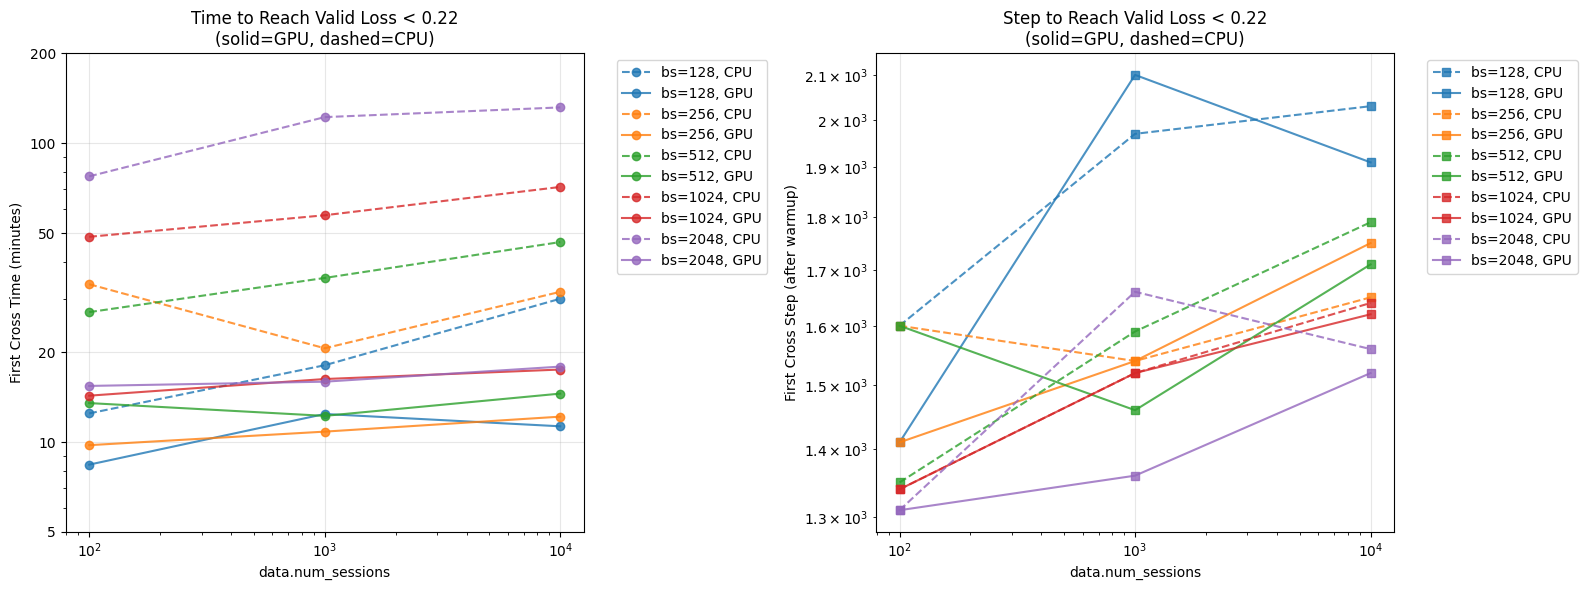

In [44]:
## 11. Create Plot: First Cross Time and Step vs num_sessions

# Create plot with two subplots: wall time and step
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Get unique batch sizes and devices
batch_sizes = sorted(cross_plot_df['data.batch_size'].unique())
devices = ['CPU', 'GPU']

# Define colors for each batch size
colors = plt.cm.tab10(range(len(batch_sizes)))

# Define explicit y-axis ticks
time_yticks = [5, 10, 20, 50, 100, 200]  # minutes
step_yticks = [50, 100, 200, 500, 1000, 2000, 5000]  # steps

# --- Left plot: First Cross Wall Time ---
for i, bs in enumerate(batch_sizes):
    for device in devices:
        data = cross_plot_df[
            (cross_plot_df['data.batch_size'] == bs) &
            (cross_plot_df['device'] == device)
        ].sort_values('data.num_sessions')
        
        if len(data) > 0 and data['first_cross_wall_time'].notna().any():
            linestyle = '-' if device == 'GPU' else '--'
            label = f'bs={int(bs)}, {device}'
            
            ax1.plot(
                data['data.num_sessions'],
                data['first_cross_wall_time'] / 60,
                marker='o',
                linestyle=linestyle,
                color=colors[i],
                label=label,
                alpha=0.8
            )

ax1.set_xlabel('data.num_sessions')
ax1.set_ylabel('First Cross Time (minutes)')
ax1.set_title(f'Time to Reach Valid Loss < {threshold}\n(solid=GPU, dashed=CPU)')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(True, alpha=0.3)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_yticks(time_yticks)
ax1.get_yaxis().set_major_formatter(ScalarFormatter())

# --- Right plot: First Cross Step (after warmup) ---
for i, bs in enumerate(batch_sizes):
    for device in devices:
        data = cross_plot_df[
            (cross_plot_df['data.batch_size'] == bs) &
            (cross_plot_df['device'] == device)
        ].sort_values('data.num_sessions')
        
        if len(data) > 0 and data['first_cross_step'].notna().any():
            linestyle = '-' if device == 'GPU' else '--'
            label = f'bs={int(bs)}, {device}'
            
            ax2.plot(
                data['data.num_sessions'],
                data['first_cross_step'],
                marker='s',
                linestyle=linestyle,
                color=colors[i],
                label=label,
                alpha=0.8
            )

ax2.set_xlabel('data.num_sessions')
ax2.set_ylabel('First Cross Step (after warmup)')
ax2.set_title(f'Step to Reach Valid Loss < {threshold}\n(solid=GPU, dashed=CPU)')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.grid(True, alpha=0.3)
ax2.set_xscale('log')
ax2.set_yscale('log')
# ax2.set_yticks(step_yticks)
ax2.get_yaxis().set_major_formatter(ScalarFormatter())

plt.tight_layout()
plt.show()